## Training Pipeline for Lung Tumor Segmentation

In this notebook, we train a U-Net-based segmentation model using PyTorch Lightning. The goal is to detect and segment tumors in 2D CT slices from the Decathlon lung dataset.

We use a custom dataset with preprocessed slices and masks (`.npy` format) and train the model with weighted sampling, augmentations, a custom loss, and TensorBoard logging.


In [26]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from model import UNet
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np
import imgaug.augmenters as iaa
from pathlib import Path
from dataset import LungDataset

### 1. Data Augmentation

To improve generalization and robustness, we apply a combination of spatial transformations using `imgaug`:
- **Affine** transformations (rotation ±45°, scaling between 0.85 and 1.15)
- **Elastic deformation** to simulate anatomical variability

These augmentations are applied only to the training dataset and are synchronized between images and masks.

In [2]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

### 2. Dataset Setup

We use the `LungDataset` class to load preprocessed 2D slices.

Key points:
- Each slice has a corresponding mask
- Masks are binary (tumor vs. background)
- We apply **weighted random sampling** to increase the probability of sampling slices that contain tumors, which helps mitigate severe class imbalance

We then wrap the datasets in PyTorch `DataLoader`s, using:
- `WeightedRandomSampler` for the training set
- Standard shuffling off for validation

In [3]:
path = Path("../datos/Preprocessed/train/")
path_val = Path("../datos/Preprocessed/val/")
train_dataset = LungDataset(path, augment_params=seq,tumor_oversampling_factor=8)
val_dataset = LungDataset(path_val, augment_params=None)

sampler = torch.utils.data.WeightedRandomSampler(
    weights=train_dataset.weights,
    num_samples=len(train_dataset),
    replacement=True
)

In [4]:
batch_size = 12
num_workers = 8

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         num_workers=num_workers, shuffle=False)

In [ ]:
print("\n=== Verificación de un batch ===")
x, y = next(iter(train_loader))
print("Input:", x.shape, x.dtype, f"[{x.min():.2f}, {x.max():.2f}]")
print("Mask:", y.shape, y.dtype, "Valores únicos:", torch.unique(y))

assert x.shape[1:] == (1, 256, 256), "Tamaño incorrecto"
assert y.shape[1:] == (1, 256, 256), "Tamaño incorrecto en máscara"
assert x.max() <= 1.0 and x.min() >= 0.0, "Input fuera de rango [0, 1]"
assert torch.all((y == 0) | (y == 1)), "Máscara no binaria"
print("✅ Verificación pasada. Listo para entrenar.\n")

## Loss

As this is a harder task to train you might try different loss functions:
We achieved best results by using the Binary Cross Entropy instead of the Dice Loss

### 3. Model Definition with PyTorch Lightning

We define a `TumorSegmentation` model as a `LightningModule`, which includes:
- A U-Net for binary segmentation
- A hybrid **Focal + Dice loss** (`DiceFocalLoss` from MONAI), balanced with custom weights:
  - `lambda_focal=1.7` (to focus on difficult examples)
  - `lambda_dice=0.3` (to reward overlap with true mask)
- `Adam` optimizer with a learning rate of `1e-4`
- Sigmoid applied during evaluation but not during training (loss expects logits)

The model logs:
- Raw predictions and overlays for visual monitoring
- Custom debug metrics on tumor area and false positives

In [5]:
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet()
        self.loss_fn = DiceFocalLoss(
            sigmoid=True,
            include_background=True,
            gamma=2.0,
            lambda_dice=0.3,
            lambda_focal=1.7,
            reduction="mean"
        )

    def forward(self, x):
        return self.model(x)

    def _log_images(self, x, y, y_hat, stage):
        y_hat_np = y_hat[0][0].detach().cpu().numpy()

        fig = plt.figure(figsize=(15, 4))

        plt.subplot(1, 4, 1)
        plt.imshow(x[0][0].cpu(), cmap='bone')
        plt.title('Input')

        plt.subplot(1, 4, 2)
        plt.imshow(y[0][0].cpu(), cmap='gray')
        plt.title('Ground Truth')

        plt.subplot(1, 4, 3)
        plt.imshow(y_hat_np, cmap='hot', vmin=0, vmax=1)
        plt.title('Raw Prediction (y_hat)')

        plt.subplot(1, 4, 4)
        plt.imshow(x[0][0].cpu(), cmap='bone')
        mask_overlay = np.ma.masked_where(y_hat_np < 0.2, y_hat_np)
        plt.imshow(mask_overlay, cmap='autumn', alpha=0.5)
        plt.title('Overlay (y_hat > 0.2)')

        self.logger.experiment.add_figure(f'{stage}_raw_logits', fig, self.global_step)
        plt.close(fig)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)

        probs = torch.sigmoid(y_hat)
        preds = probs > 0.2

        if batch_idx % 100 == 0:
            self._log_images(x, y, y_hat, 'train')

        if self.global_step % 200 == 0:
            self.log("debug/pred_area", preds.sum() / preds.numel())
            self.log("debug/gt_area", y.sum() / y.numel())
            self.log("debug/diff_area", (preds.sum() - y.sum()) / y.numel())

        dice = (2 * (preds * y).sum()) / (preds.sum() + y.sum() + 1e-6)
        self.log("train_dice", dice)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)

        probs = torch.sigmoid(y_hat)
        preds = probs > 0.2

        if y.sum() > 0:
            dice = (2 * (preds * y).sum()) / (preds.sum() + y.sum() + 1e-6)
            self.log('val_dice', dice, prog_bar=True)

        if batch_idx % 20 == 0:
            self._log_images(x, y, y_hat, 'val')

        if self.global_step % 200 == 0:
            self.log("debug/pred_area", preds.sum() / preds.numel())
            self.log("debug/gt_area", y.sum() / y.numel())
            self.log("debug/diff_area", (preds.sum() - y.sum()) / y.numel())

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

### 4. Logging and Callbacks

We use:
- **TensorBoardLogger** to track training metrics and view images
- **ModelCheckpoint** to save the top 3 models by validation Dice
- **EarlyStopping** to stop training if no improvement in `val_dice` is observed over 25 epochs

Here's a simple verification of everything going well before start training

In [ ]:
# 1. Verificar shapes y tipos
sample = next(iter(train_loader))
x, y = sample
print(f"Batch shapes - X: {x.shape}, Y: {y.shape}")
print(f"Data ranges - X: [{x.min()}, {x.max()}], Y unique: {torch.unique(y)}")

model = TumorSegmentation()
out = model(x)
print(f"Model output - Shape: {out.shape}, Range: [{torch.sigmoid(out).min()}, {torch.sigmoid(out).max()}]")


loss = model.loss_fn(out, y)
print(f"Loss value: {loss.item()} (should be >0)")

r
sampled_batch = next(iter(train_loader))
masks = sampled_batch[1]  # Shape: (B, 1, 256, 256)
tumor_slices = (masks.sum(dim=(1, 2, 3)) > 0).sum().item()
print(f"Slices con tumor en batch: {tumor_slices}/{masks.shape[0]}")

### 5. Training Execution

Training is launched with the PyTorch Lightning `Trainer`:
- Up to 100 epochs
- GPU acceleration if available
- All logs saved to `../logs/lung-tumor/`
- Best models saved to `../weights/` with filenames including epoch and `val_dice`

In [8]:
model = TumorSegmentation()

checkpoint_callback = ModelCheckpoint(
    monitor="val_dice",
    mode="max",
    save_top_k=3,
    filename="tumor-{epoch:02d}-{val_dice:.4f}",
    dirpath="../weights"
)

early_stopping = EarlyStopping(
    monitor="val_dice",
    mode="max",
    patience=25,
    min_delta=0.001,
    verbose=True
)

logger = TensorBoardLogger(save_dir="../logs", name="lung-tumor")

trainer = Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stopping],
    logger=logger,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    log_every_n_steps=1
)

trainer.fit(model, train_loader, val_loader)



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | model   | UNet          | 7.2 M 
1 | loss_fn | DiceFocalLoss | 0     
------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.817    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

C:\Users\demonki\anaconda3\envs\pytorchenv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Reflections After Training

After training the model for up to 100 epochs, we observed that performance stabilized relatively early.

- The **training Dice score** and **training loss** converged to good values by around epoch 17–18, indicating that the model had successfully learned from the available data.
- The **validation Dice score** fluctuated between 0.15 and 0.25, with no clear upward trend beyond that range.
- From the **debug metrics** and overlay visualizations in TensorBoard, we saw that the model was starting to segment tumor regions reasonably well, especially given the challenging nature of the data.

At this point, we made the decision to stop further training because:

- Tumors are **extremely small and rare** across the dataset, which makes learning and generalization inherently difficult.
- The dataset is **very limited in size**, and many slices contain no tumor at all, reducing the effective signal the model can learn from.
- We are working under **modest computational constraints**, and this model already reaches a balance between performance and feasibility.

Overall, the model has started to identify tumors in a consistent and meaningful way. While it may not reach perfect segmentation quality, we believe that this is a **realistic and reliable result** given the nature of the task and the data.


## Post-Training Evaluation: Patient-Level Dice

After reviewing the training logs and validation metrics, we decided to perform a more realistic evaluation of the model by computing the **Dice score at the patient level**.

Instead of evaluating individual slices, this approach processes all slices of a validation patient, makes predictions for each, and then computes a global Dice score using all pixels from the volume. This better simulates how the model would perform in a real-world clinical setting, where predictions are made over entire CT scans.

This method provides several benefits:
- It captures **both sensitivity and specificity** across the full volume
- It is more stable than per-slice Dice, which can be misleading due to the high proportion of background-only slices
- It allows us to observe how the model behaves **across different patients**, especially those with tumors

The results confirmed what we observed qualitatively:
- The patient-wise Dice scores were in line with the slice-level validation Dice from training (typically between 0.15 and 0.25)
- Patients with more obvious tumors tended to have better Dice scores
- In some cases, the model missed very small tumors or predicted small false positives

Despite these limitations, the predictions were consistent and showed that the model had **learned to localize tumors to a reasonable degree**, given the class imbalance and data constraints.

This evaluation supports our earlier decision to stop training and affirms that the current model is a solid baseline under the current setup.


In [27]:
model = TumorSegmentation.load_from_checkpoint("../weights/tumor-epoch=13-val_dice=0.2937.ckpt")
model.eval()
model.to("cuda" or "cpu") 
THRESHOLD = 0.2


In [29]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


# Dice score function
def dice_score(pred, target, eps=1e-6):
    pred = (pred > 0.2).float()
    target = target.float()
    intersection = (pred * target).sum()
    return (2. * intersection + eps) / (pred.sum() + target.sum() + eps)

# Load patient slices and masks from validation folder
def load_patient_volume(patient_dir):
    slice_dir = patient_dir / "data"
    mask_dir = patient_dir / "masks"
    slices = []
    masks = []
    for file in sorted(slice_dir.glob("*.npy")):
        slice = np.load(file).astype(np.float32)
        mask = np.load(mask_dir / file.name).astype(np.uint8)
        slices.append(slice)
        masks.append(mask)
    return np.stack(slices), np.stack(masks)

# Predict entire patient volume
def predict_volume(slices):
    preds = []
    device = "cuda" if torch.cuda.is_available() else "cpu"
    for sl in slices:
        inp = torch.tensor(sl[None, None, ...], dtype=torch.float32).to(device)
        with torch.no_grad():
            out = model(inp)
            preds.append(out.cpu().squeeze(0).squeeze(0).numpy())
    return np.stack(preds)

# Run evaluation over validation patients
VAL_PATH = Path("../datos/Preprocessed/val")
scores = []

for patient_dir in sorted(VAL_PATH.iterdir()):
    slices, masks = load_patient_volume(patient_dir)
    preds = predict_volume(slices)

    dice = dice_score(torch.tensor(preds), torch.tensor(masks))
    scores.append((patient_dir.name, dice.item()))
    print(f"{patient_dir.name} - Dice: {dice:.4f}")

# Summary
all_scores = [score for _, score in scores]
print("\n=== Patient-Level Validation Summary ===")
print(f"Mean Dice: {np.mean(all_scores):.4f}")
print(f"Median Dice: {np.median(all_scores):.4f}")


57 - Dice: 0.3622
58 - Dice: 0.5761
59 - Dice: 0.5548
60 - Dice: 0.0167
61 - Dice: 0.5480
62 - Dice: 0.0000

=== Patient-Level Validation Summary ===
Mean Dice: 0.3430
Median Dice: 0.4551


In [18]:
import nibabel as nib
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm

def load_nifti_image(path):
    nii = nib.load(str(path))
    return nii.get_fdata().astype(np.float32)  # (H, W, D)

def apply_ct_window(image, level=-600, width=1500):
    min_hu = level - width // 2
    max_hu = level + width // 2
    windowed = np.clip(image, min_hu, max_hu)
    return (windowed - min_hu) / width


imagesTs_path = Path("../datos/imagesTs")
save_root = Path("../datos/Preprocessed/test")


nii_files = sorted([f for f in imagesTs_path.glob("*.nii.gz") if not f.name.startswith("._")])

for nii_path in tqdm(nii_files):
    ct_data = load_nifti_image(nii_path)
    

    ct_data = ct_data[:, :, 30:] 
    ct_data = apply_ct_window(ct_data, level=-600, width=1500)

    patient_id = nii_path.stem.replace(".nii", "") 
    current_path = save_root / patient_id / "data"
    current_path.mkdir(parents=True, exist_ok=True)
    
    for i in range(ct_data.shape[-1]):
        slice_img = ct_data[:, :, i]
        slice_img = cv2.resize(slice_img, (256, 256))
        np.save(current_path / f"{i}.npy", slice_img.astype(np.float32))


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:19<00:00,  4.35s/it]


## Evaluation on the Test Set and Visual Inspection

To complement the quantitative evaluation on the validation set, we also ran the model on the **test dataset**. This set contains only CT volumes without ground truth masks, simulating a real-world deployment scenario.

For each test patient:
- The model predicts the tumor segmentation slice by slice
- We generate a **video** stored in the `videos/` folder that overlays the model's predictions on top of the CT image
- These visualizations allow us to qualitatively assess the model’s performance

While the model does produce some false positives—likely due to the complexity and noise of the input data—its behavior is consistent. Importantly, when the tumor is visibly present in the CT, the model is generally **able to detect it** and produce a segmentation that matches well with what a human expert might identify.

This gives us additional confidence that, despite the limited dataset and challenging nature of the task, the model has learned to **recognize key tumor features** and can serve as a useful tool for supporting medical analysis.


Evaluating patient: lung_002


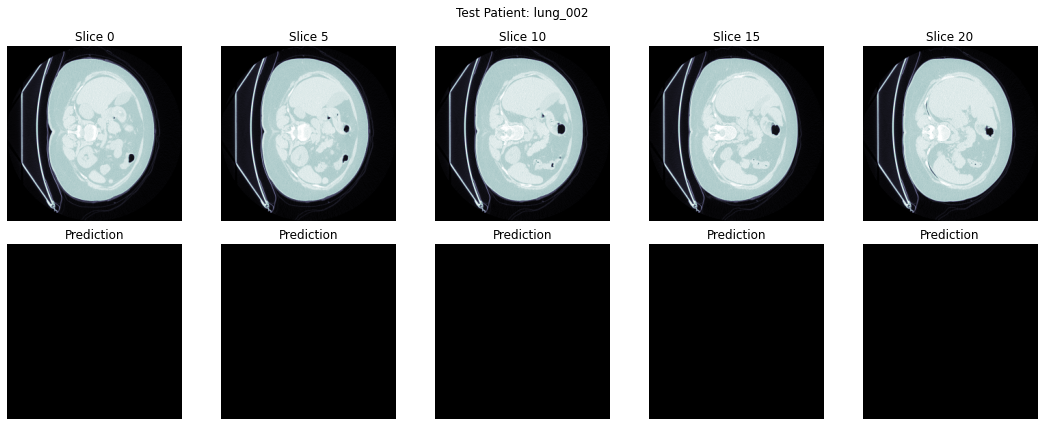

Saved video to: videos\lung_002_segmentation.mp4
Evaluating patient: lung_007


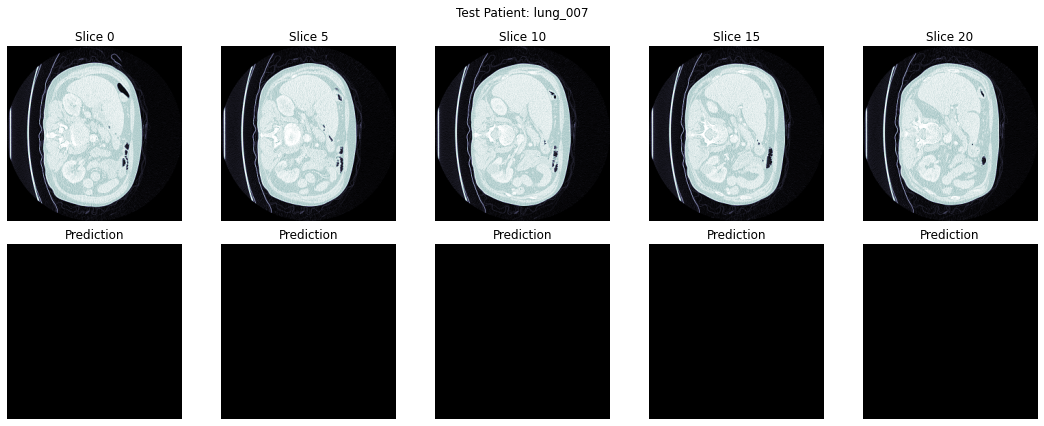

Saved video to: videos\lung_007_segmentation.mp4
Evaluating patient: lung_008


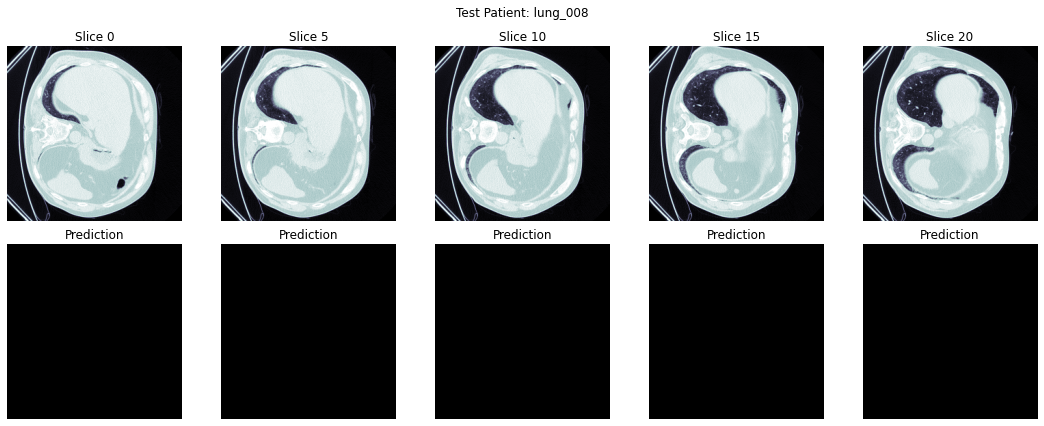

Saved video to: videos\lung_008_segmentation.mp4
Evaluating patient: lung_011


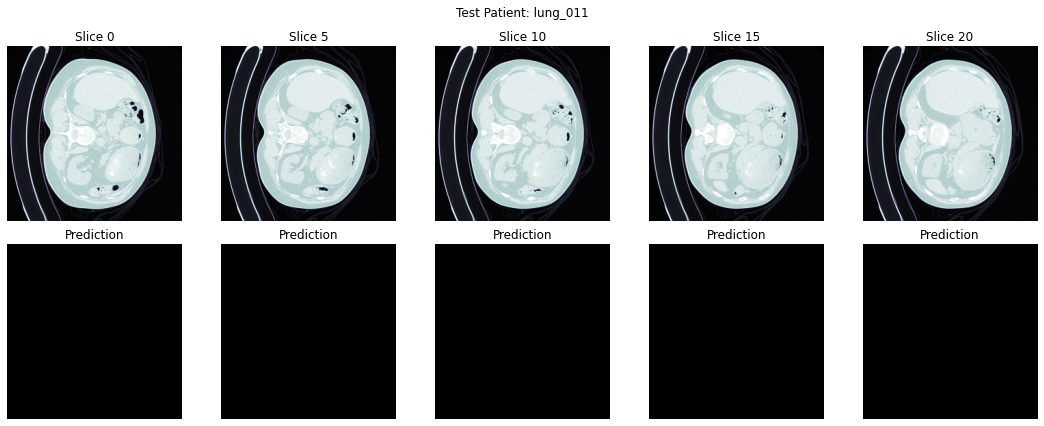

Saved video to: videos\lung_011_segmentation.mp4
Evaluating patient: lung_012


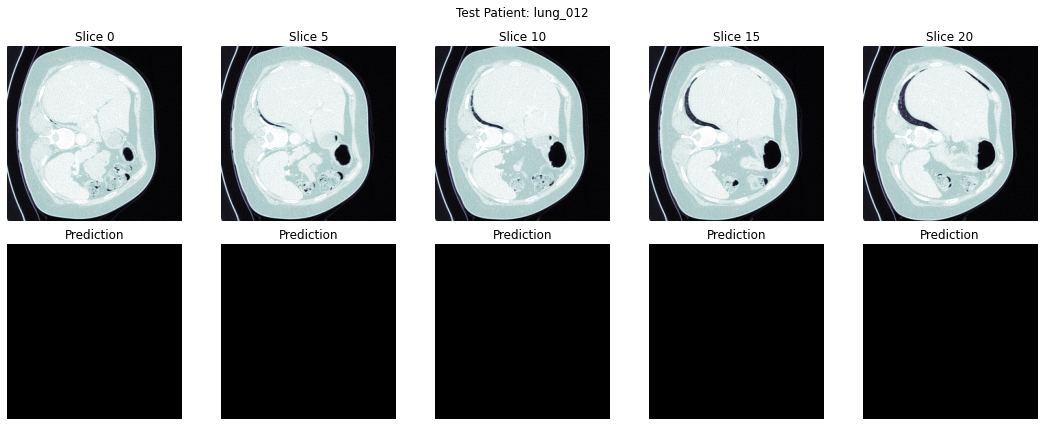

Saved video to: videos\lung_012_segmentation.mp4
Evaluating patient: lung_013


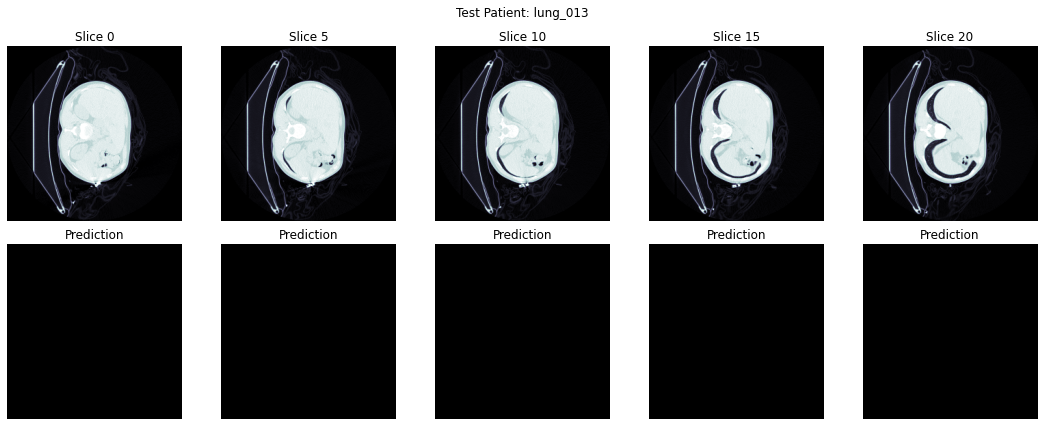

Saved video to: videos\lung_013_segmentation.mp4
Evaluating patient: lung_017


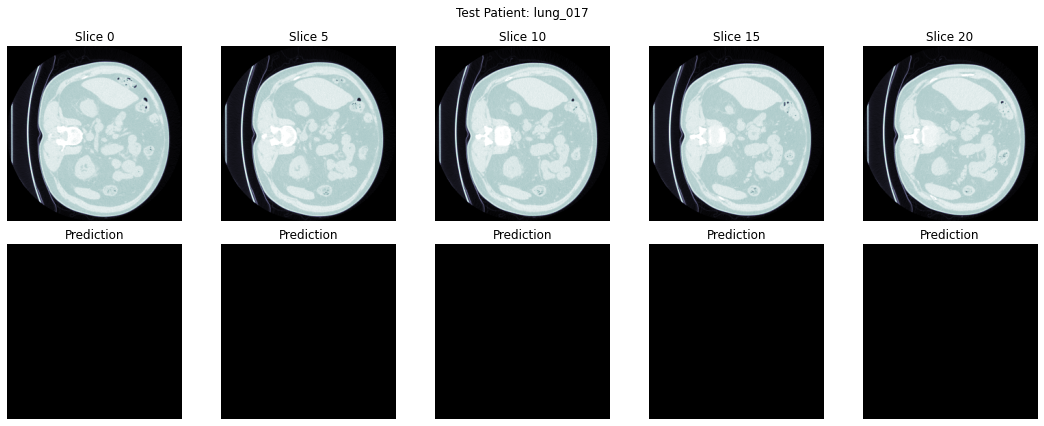

Saved video to: videos\lung_017_segmentation.mp4
Evaluating patient: lung_019


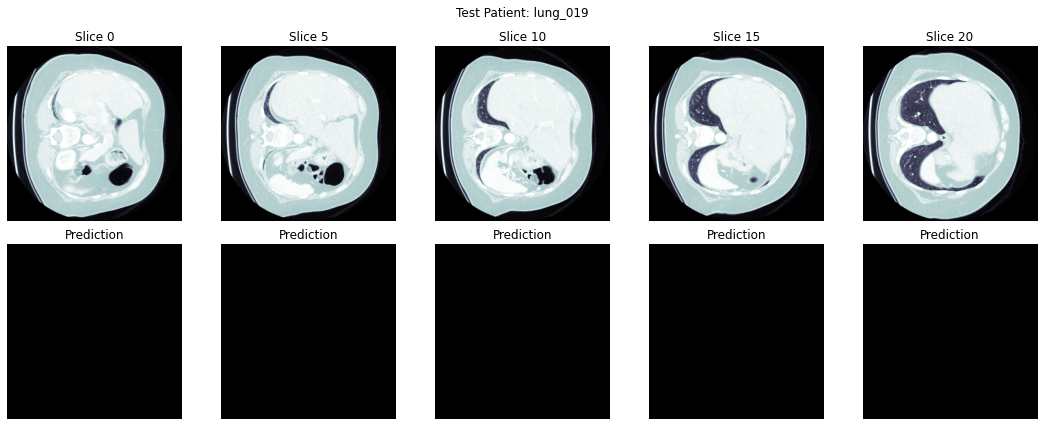

Saved video to: videos\lung_019_segmentation.mp4
Evaluating patient: lung_021


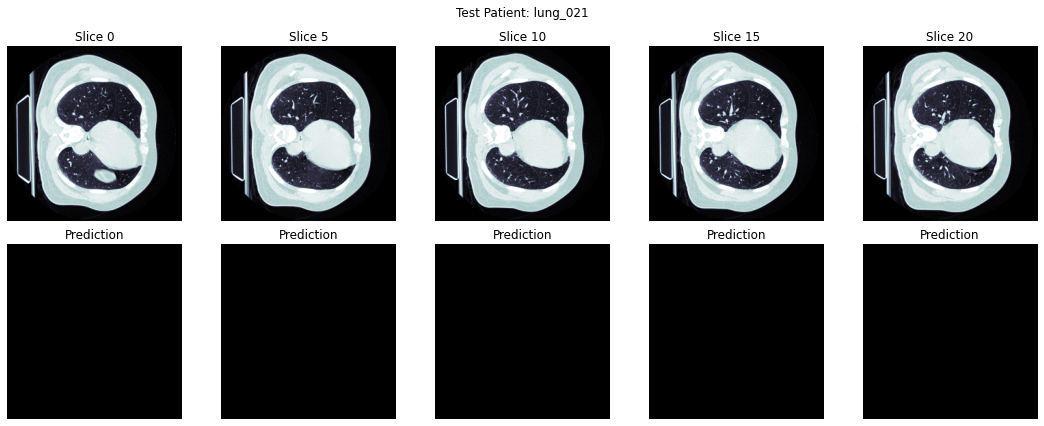

Saved video to: videos\lung_021_segmentation.mp4
Evaluating patient: lung_024


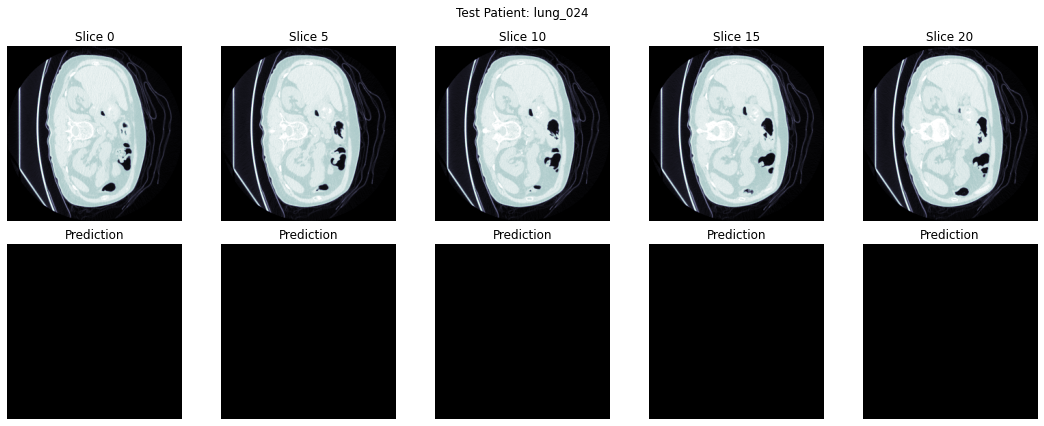

Saved video to: videos\lung_024_segmentation.mp4
Evaluating patient: lung_030


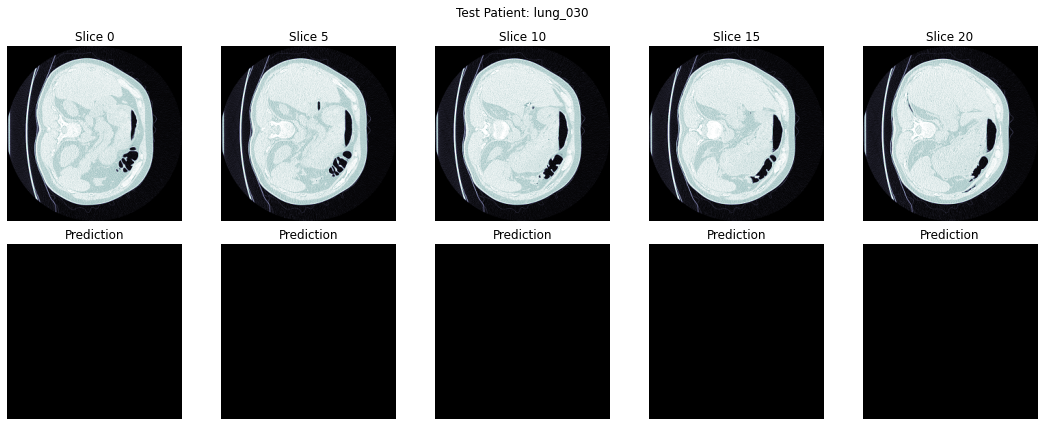

KeyboardInterrupt: 

IndexError: list index out of range

<Figure size 720x360 with 2 Axes>

In [24]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib as mpl
from matplotlib.animation import FFMpegWriter
mpl.rcParams['animation.embed_limit'] = 50  # Aumenta a 50 MB

def dice_score(pred, target, eps=1e-6):
    pred = (pred > THRESHOLD).float()
    target = target.float()
    intersection = (pred * target).sum()
    return (2. * intersection + eps) / (pred.sum() + target.sum() + eps)

def load_patient_slices(patient_dir):
    slice_dir = patient_dir / "data"
    mask_dir = patient_dir / "masks"
    slices = []
    masks = []
    for file in sorted(slice_dir.glob("lung_*")):
        slice = np.load(file).astype(np.float32)
        mask = np.load(mask_dir / file.name).astype(np.uint8)
        slices.append(slice)
        masks.append(mask)
    return np.stack(slices), np.stack(masks)

def predict_patient(slices_np):
    preds = []
    for sl in slices_np:
        inp = torch.tensor(sl[None, None, ...], dtype=torch.float32).to(DEVICE)
        with torch.no_grad():
            out = model(inp)
            preds.append(out.cpu().squeeze(0).squeeze(0).numpy())
    return np.stack(preds)

def visualize_test_patient(slices, preds, patient_name, step=5):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    idxs = list(range(0, len(slices), step))[:5]

    for i, idx in enumerate(idxs):
        axes[0, i].imshow(slices[idx], cmap="bone")
        axes[0, i].set_title(f"Slice {idx}")
        axes[0, i].axis("off")

        axes[1, i].imshow(preds[idx] > THRESHOLD, cmap="gray")
        axes[1, i].set_title("Prediction")
        axes[1, i].axis("off")

    plt.suptitle(f"Test Patient: {patient_name}")
    plt.tight_layout()
    plt.show()

def save_test_segmentation_video(slices, preds, patient_name, output_path):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    def update(i):
        ax[0].cla()
        ax[1].cla()

        ax[0].imshow(slices[i], cmap="bone")
        ax[0].set_title(f"Slice {i}")
        ax[0].axis("off")

        ax[1].imshow(preds[i] > THRESHOLD, cmap="gray")
        ax[1].set_title("Prediction")
        ax[1].axis("off")

    ani = FuncAnimation(fig, update, frames=len(slices), repeat=False)
    writer = FFMpegWriter(fps=5)
    ani.save(output_path, writer=writer)
    plt.close()

TEST_NII_PATH = Path("../datos/imagesTs")
for nii_file in sorted(TEST_NII_PATH.glob("*.nii.gz"))[:5]:
    if nii_file.name.startswith("._"):
        continue

    patient_name = nii_file.stem.replace(".nii", "")
    print(f"Evaluating patient: {patient_name}")


    ct_data = load_nifti_image(nii_file)
    ct_data = ct_data[:, :, 30:] 
    ct_data = apply_ct_window(ct_data, level=-600, width=1500)
    slices = np.moveaxis(ct_data, -1, 0)  # (N, H, W)
    slices = np.stack([cv2.resize(slice, (256, 256)) for slice in slices])

    preds = predict_patient(slices)
    
    visualize_test_patient(slices, preds, patient_name)

    output_path = Path("videos") / f"{patient_name}_segmentation.mp4"
    output_path.parent.mkdir(parents=True, exist_ok=True)
    save_test_segmentation_video(slices, preds, patient_name, str(output_path))
    print(f"Saved video to: {output_path}")


## Final Thoughts and Conclusion

This project has been a deep and hands-on exploration of applying deep learning to medical image segmentation, specifically targeting the detection of lung tumors in CT scans.

Throughout the process, we faced several real-world challenges:

- **Extreme class imbalance**, with most CT slices containing no tumor
- **Very small lesion sizes**, often just a few pixels wide, making segmentation highly sensitive
- **Limited dataset size and computational resources**, which constrained the complexity of our models and training schemes

Despite these obstacles, we were able to build a working segmentation system based on a U-Net architecture. We carefully:
- Preprocessed the data to normalize intensity and reduce irrelevant anatomy
- Designed a dataset loader with weighted sampling to prioritize informative slices
- Trained the model using advanced loss functions tailored to medical tasks (Dice + Focal)
- Evaluated performance both numerically (Dice score) and qualitatively (visual overlays and videos)

What matters most is that the model **learned to localize tumor regions**, even if imperfectly. On visual inspection, it reacts consistently to the presence of lesions and shows reasonable predictions across patients. 

We acknowledge that performance is far from perfect — and that’s okay. With the data we had and the nature of the problem, **this result is not only acceptable, it is realistic**. It shows that even with modest resources, meaningful medical AI solutions can be developed.

This project has been an excellent exercise in bridging the gap between research prototypes and practical clinical applications. It highlights the importance of understanding the data, designing carefully, and setting realistic expectations.

The next steps could include:
- Expanding the dataset (more patients, more tumors)
- Exploring semi-supervised training
- Integrating model interpretability techniques
- Building a small web demo to showcase the system

For now, we consider this a solid foundation and a successful completion of our initial goal.
